**Convolutional Neural Network (CNN) basierend auf die YOLO-Architektur zur Erkennung von deutschen Verkehrszeichen in Echtzeit mit dem GTSRB-Dataset**

Autoren: Laieb Ahmad, Enes Bayar, Mehmet Akif Onur & Mert-Can Öksuz
<br>
Datum: 19.08.2024
<br>
Modul: KI-DL/ML
<br>
Dozent: Prof. Dr. Stephan Schneider

## **Befehle zum Installieren/Upgraden von Packages**


In [ ]:
%%bash 
pip install wandb --upgrade
pip install numpy --upgrade
pip install pandas --upgrade
pip install scikit-learn --upgrade
pip install scikit-image --upgrade
pip install pillow --upgrade
pip install imbalanced-learn --upgrade
pip install statsmodels --upgrade
pip install matplotlib --upgrade
pip install seaborn --upgrade
pip install tensorflow --upgrade
pip install ultralytics --upgrade
pip install pyyaml --upgrade
pip install kaggle --upgrade

## **Laden von Packages + Anzeigen der Versionen**

In [ ]:
from ultralytics import YOLO
from helfer_funktionen import copy_images_and_convert_annotations, get_filenames, read_images, images_to_array, plot_images_with_annotations, write_yaml_to_file, plot_class_distribution
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import csv
import torch
import wandb
import yaml
import imagesize


print("Package 'Numpy':", np.__version__)
print("Package 'Pandas':", pd.__version__)
print("Package 'OpenCV':", cv2.__version__)
print("Package 'CSV':", csv.__version__)
print("Package 'PyTorch':", torch.__version__)
print("Package 'WandB':", wandb.__version__)
print("Package 'YAML':", yaml.__version__)

Package 'Numpy': 1.26.4
Package 'Pandas': 2.2.3
Package 'OpenCV': 4.10.0
Package 'CSV': 1.0
Package 'PyTorch': 2.4.1+cpu
Package 'WandB': 0.18.3
Package 'YAML': 6.0.1


## **Installieren von Yolov5**


In [ ]:
!git clone https://github.com/ultralytics/yolov5

%%bash
cd yolov5
pip install -r requirements.txt

## **Importieren des Datensatzes**

In [ ]:
#kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

#Anzahl der Bilder pro Klasse im Trainingsdatensatz
path_train = r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\gtsrb-german-traffic-sign\versions\1\Train"
total_images = 0
for i in range(0, 43):
    path = os.path.join(path_train, str(i))
    num_images = len(os.listdir(path))
    total_images += num_images
print("Gesamtanzahl der Trainings-Bilder:", total_images)

#Anzahl der Bilder pro Klasse im Trainingsdatensatz
path_test = r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\gtsrb-german-traffic-sign\versions\1\Test"
num_images = len(os.listdir(path_test))
print("Gesamtanzahl der Test-Bilder:", num_images)

Gesamtanzahl der Trainings-Bilder: 39209
Gesamtanzahl der Test-Bilder: 12631


## **Splitten des Datensatz in Train, Test und Validatio und konvertieren der Annotationen ins YOLO-Format**

In [ ]:
#Definieren der Verzeichnisse
base_path = r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\gtsrb-german-traffic-sign\versions\1"
train_image_base_dir = os.path.join(base_path, "Train")
test_image_dir = os.path.join(base_path, "Test")
train_csv_path = os.path.join(base_path, "Train.csv")
test_csv_path = os.path.join(base_path, "Test.csv")

#Laden der CSV-Dateien
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

#Splitten des Trainingsdatensatzes in Training und Validation (80%/20%)
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

#Erstellen der Verzeichnisstruktur im YOLO-Format
os.makedirs("dataset/images/train", exist_ok=True)
os.makedirs("dataset/images/val", exist_ok=True)
os.makedirs("dataset/images/test", exist_ok=True)
os.makedirs("dataset/labels/train", exist_ok=True)
os.makedirs("dataset/labels/val", exist_ok=True)
os.makedirs("dataset/labels/test", exist_ok=True)

#Ausführen des Kopier- und Konvertierungsprozesses für Trainings-, Validierungs- und Testdatensätze (in den obigen Verzeichnissen)
copy_images_and_convert_annotations(train_df, "train", train_image_base_dir)
copy_images_and_convert_annotations(val_df, "val", train_image_base_dir)
copy_images_and_convert_annotations(test_data, "test", test_image_dir)

31367 Dateien wurden für den Split 'train' kopiert.
7842 Dateien wurden für den Split 'val' kopiert.
12630 Dateien wurden für den Split 'test' kopiert.


## **Übersicht über die Klassenverteilung im Datensatz**

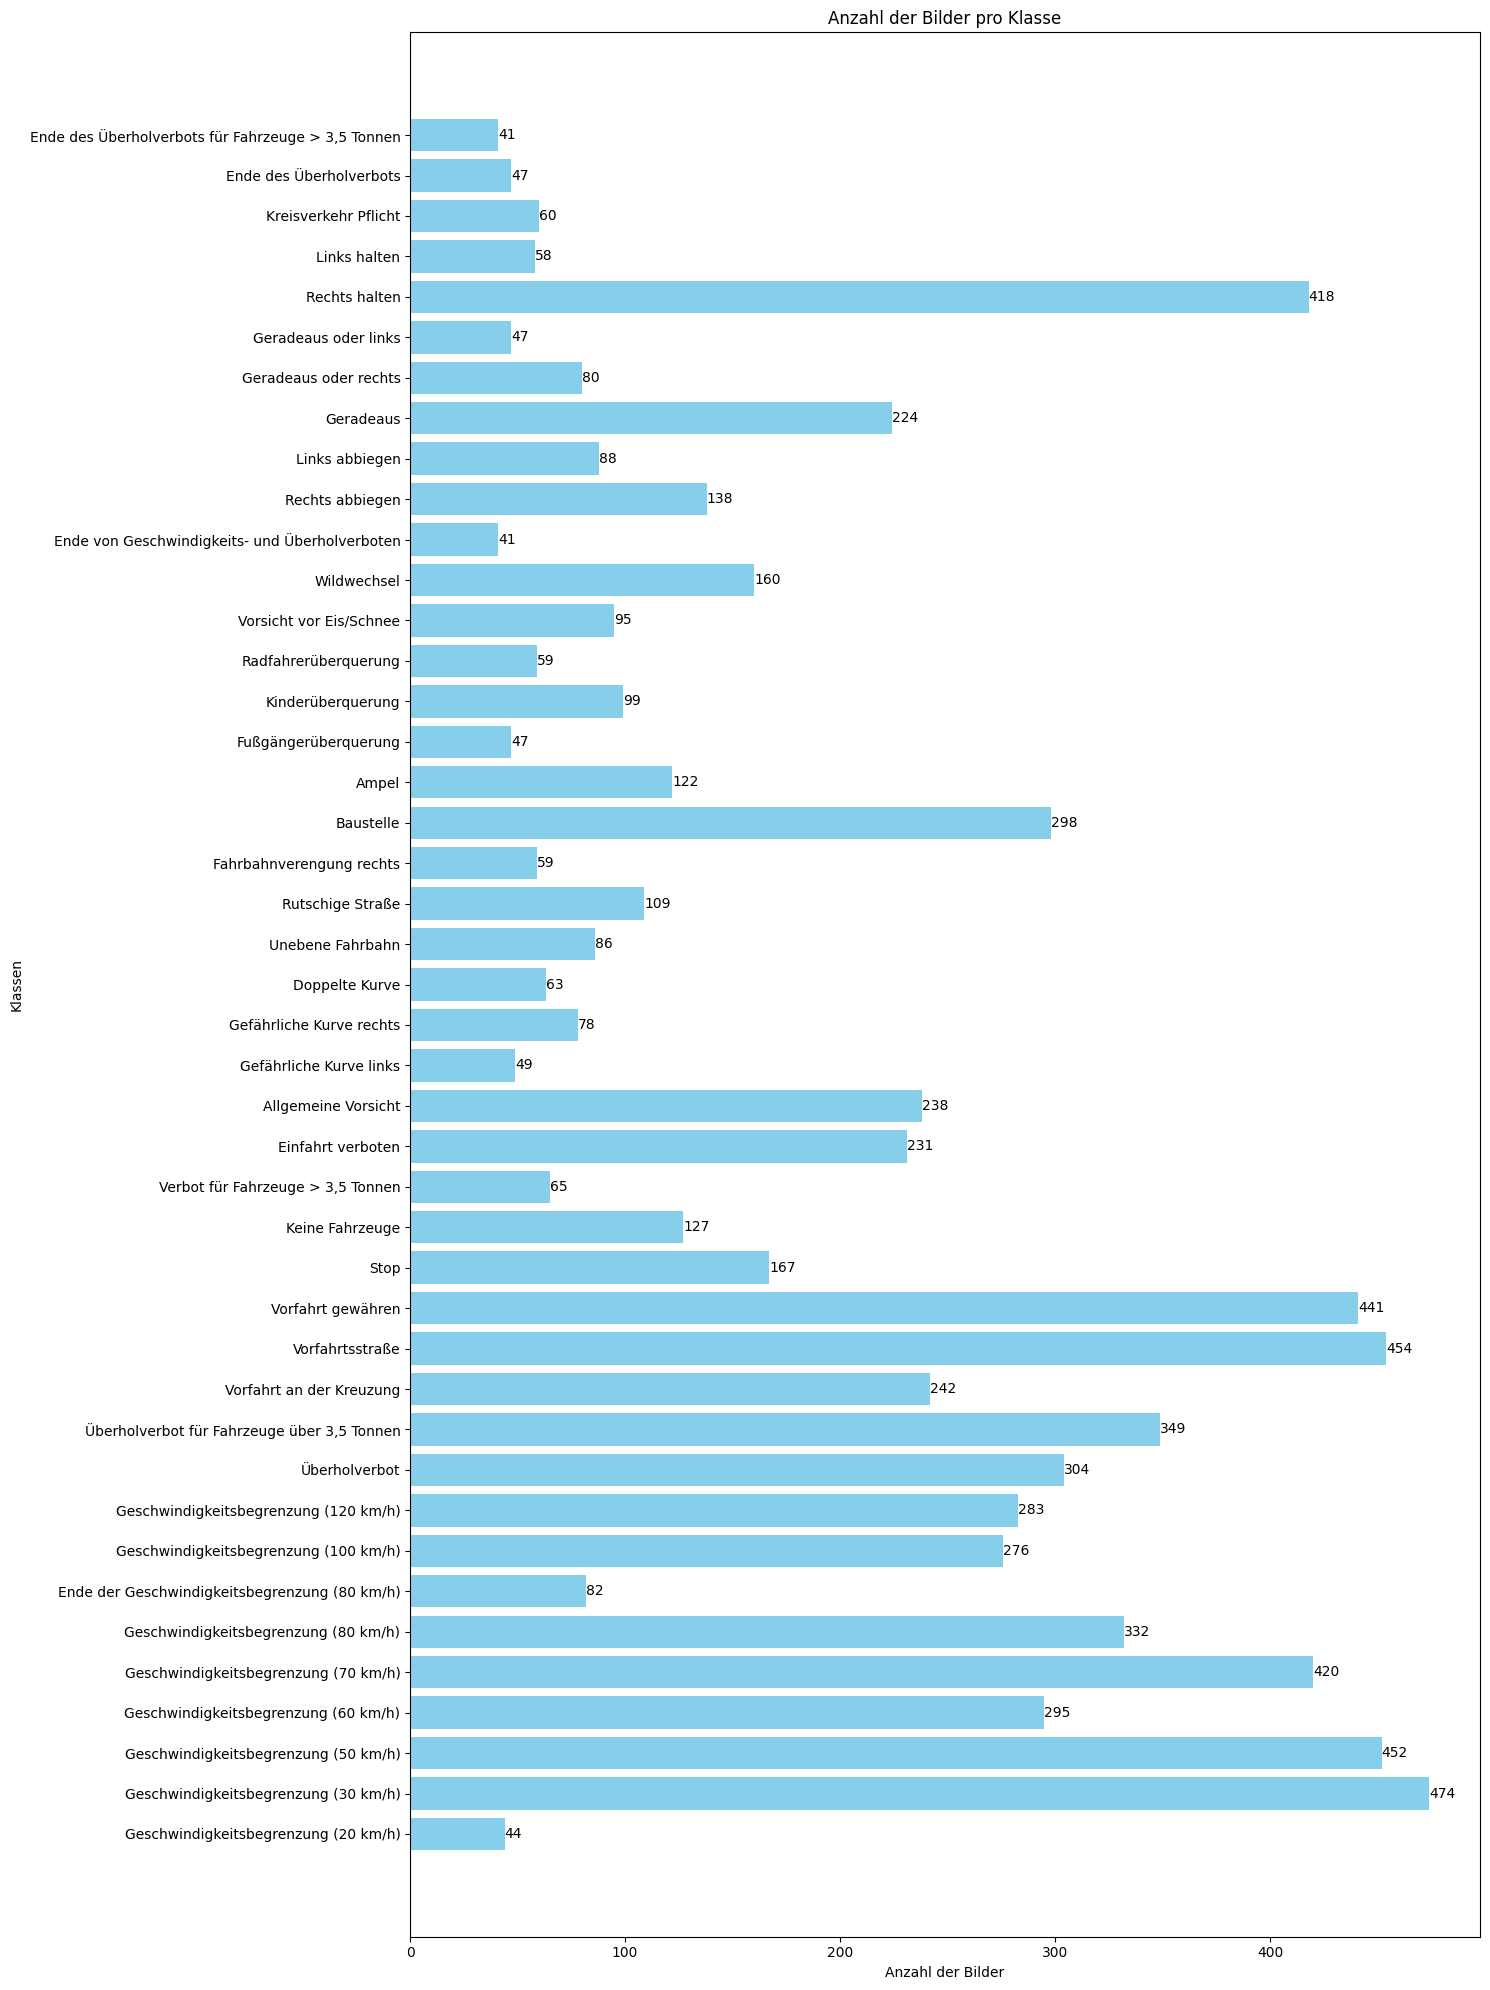

In [ ]:
label_path = r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\dataset\labels\val"
class_names = [
    "Geschwindigkeitsbegrenzung (20 km/h)",
    "Geschwindigkeitsbegrenzung (30 km/h)",
    "Geschwindigkeitsbegrenzung (50 km/h)",
    "Geschwindigkeitsbegrenzung (60 km/h)",
    "Geschwindigkeitsbegrenzung (70 km/h)",
    "Geschwindigkeitsbegrenzung (80 km/h)",
    "Ende der Geschwindigkeitsbegrenzung (80 km/h)",
    "Geschwindigkeitsbegrenzung (100 km/h)",
    "Geschwindigkeitsbegrenzung (120 km/h)",
    "Überholverbot",
    "Überholverbot für Fahrzeuge über 3,5 Tonnen",
    "Vorfahrt an der Kreuzung",
    "Vorfahrtsstraße",
    "Vorfahrt gewähren",
    "Stop",
    "Keine Fahrzeuge",
    "Verbot für Fahrzeuge > 3,5 Tonnen",
    "Einfahrt verboten",
    "Allgemeine Vorsicht",
    "Gefährliche Kurve links",
    "Gefährliche Kurve rechts",
    "Doppelte Kurve",
    "Unebene Fahrbahn",
    "Rutschige Straße",
    "Fahrbahnverengung rechts",
    "Baustelle",
    "Ampel",
    "Fußgängerüberquerung",
    "Kinderüberquerung",
    "Radfahrerüberquerung",
    "Vorsicht vor Eis/Schnee",
    "Wildwechsel",
    "Ende von Geschwindigkeits- und Überholverboten",
    "Rechts abbiegen",
    "Links abbiegen",
    "Geradeaus",
    "Geradeaus oder rechts",
    "Geradeaus oder links",
    "Rechts halten",
    "Links halten",
    "Kreisverkehr Pflicht",
    "Ende des Überholverbots",
    "Ende des Überholverbots für Fahrzeuge > 3,5 Tonnen"
]
output_path = 'G:/Meine Ablage/prosjekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/dataset'

plot_class_distribution(label_path, class_names, output_path)

## **Übersicht über die Auflösungen der Bilder in dem Datensatz**

In [ ]:
#Ermitteln der Bildauflösungen
imgs = [img.name for img in Path(r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\images\train").iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(Path(r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\images\train") / f)

#In DataFrame umwandeln und Seitenverhältnis berechnen
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index()
img_meta_df.columns = ['Dateiname', 'Größe']
img_meta_df[["Breite", "Höhe"]] = pd.DataFrame(img_meta_df["Größe"].tolist(), index=img_meta_df.index)
img_meta_df["Seitenverhältnis"] = round(img_meta_df["Breite"] / img_meta_df["Höhe"], 2)

print(f'Gesamtanzahl der Bilder im Datensatz: {len(img_meta_df)}')
img_meta_df.head()

Gesamtanzahl der Bilder im Datensatz: 678


,Dateiname,Größe,Breite,Höhe,Seitenverhältnis
0,00002.jpg,"(1360, 800)",1360,800,1.7
1,00003.jpg,"(1360, 800)",1360,800,1.7
2,00004.jpg,"(1360, 800)",1360,800,1.7
3,00005.jpg,"(1360, 800)",1360,800,1.7
4,00006.jpg,"(1360, 800)",1360,800,1.7


## **Laden und Anzeigen von Trainingsbildern**

Form des Bilder-Arrays: (678, 200, 200, 3)


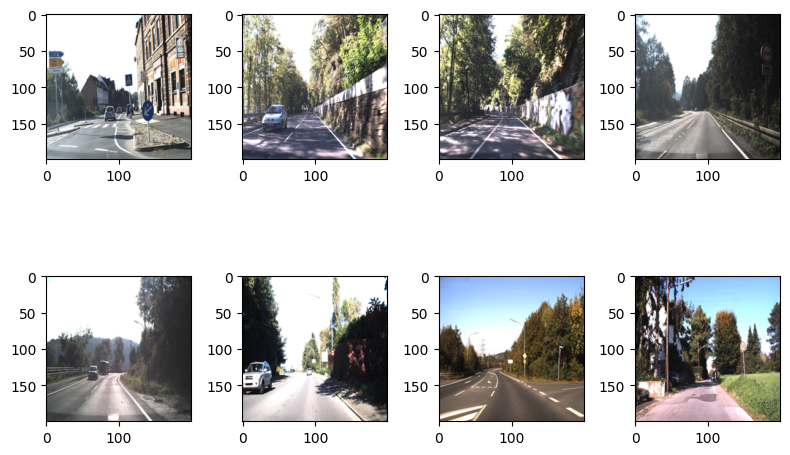

In [4]:
%matplotlib inline
filepath = r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\images\train"
image_names = get_filenames(filepath)

input_shape = {
    "height": 200,
    "width": 200,
    "channels": 3
}
images = read_images(image_names, height=input_shape["height"], width=input_shape["width"])

aimages = images_to_array(images)
print(f'Form des Bilder-Arrays: {aimages.shape}') # Struktur des Arrays: (Anzahl der Bilder, Höhe, Breite, Farbkanal)

fig = plt.figure(figsize=(8, 8))
rows, columns = 3, 4
num_images_to_display = (min(8, aimages.shape[0]))

for i in range(num_images_to_display):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(aimages[i, ...])

plt.tight_layout()

## **Testen der korrekten Umwandlung der Annotation in das YOLO-Format**
Die Funktion `plot_images_with_annotations()` visualisiert die Bilder aus der Liste `image_names` und zeigt die zugehörigen **Bounding Boxes** basierend auf den YOLO-Annotationen an.

- **Parameter**:
  - `image_names`: Liste der Pfade zu den Bildern, die angezeigt werden sollen.
  - `annotations_dir`: Verzeichnis, das die YOLO-Annotationsdateien enthält. Jede Annotation enthält Informationen zu den Objekten in den Bildern (Klasse, Position und Größe der Bounding Boxes).
  - `input_shape`: Definiert die Bildhöhe und -breite, um sicherzustellen, dass die Bounding Boxes korrekt skaliert und positioniert sind.

- **Ablauf**:
  - Die Funktion lädt jedes Bild und die zugehörige Annotation.
  - Die Bounding Boxes werden auf das Bild gezeichnet, indem die normalisierten YOLO-Koordinaten auf die tatsächliche Bildgröße umgerechnet werden.
  - Die Bilder mit den Bounding Boxes werden dann in einem Raster-Layout angezeigt, sodass die Annotationen visuell überprüft werden können.

Diese Funktion ermöglicht eine schnelle und einfache Überprüfung, ob die Bounding Boxes korrekt positioniert und skaliert sind.

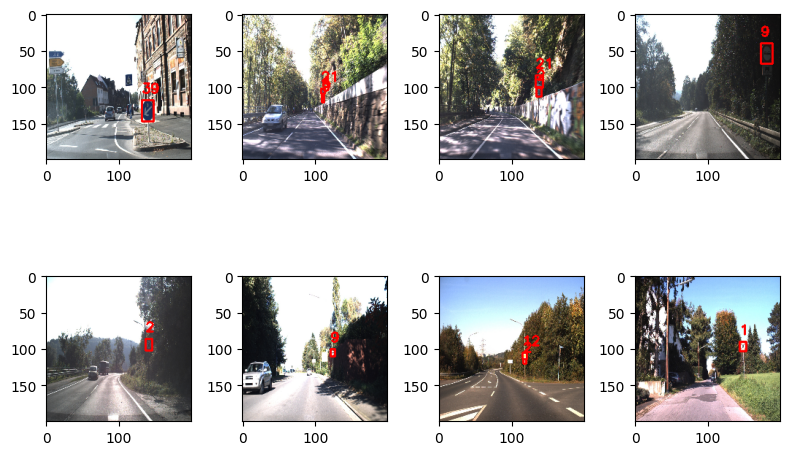

In [6]:
plot_images_with_annotations(image_names, annotations_dir=r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\labels\train", input_shape=input_shape)

## **Erstellen einer Datensatz-Konfigurations-Datei im .yaml-Format in dem Projektverzeichnis**


In [2]:
dataset_configs = {
    'path': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data',
    'train': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/train',
    'val': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/validation',
    'test': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/test',
    'nc': 43,
    'names': [
        'Geschwindigkeitsbegrenzung (20 km/h)',
        'Geschwindigkeitsbegrenzung (30 km/h)',
        'Geschwindigkeitsbegrenzung (50 km/h)',
        'Geschwindigkeitsbegrenzung (60 km/h)',
        'Geschwindigkeitsbegrenzung (70 km/h)',
        'Geschwindigkeitsbegrenzung (80 km/h)',
        'Ende der Geschwindigkeitsbegrenzung (80 km/h)',
        'Geschwindigkeitsbegrenzung (100 km/h)',
        'Geschwindigkeitsbegrenzung (120 km/h)',
        'Ueberholverbot',
        'Ueberholverbot fuer Fahrzeuge ueber 3,5 Tonnen',
        'Vorfahrt an der Kreuzung',
        'Vorfahrtsstrasse',
        'Vorfahrt gewaehren',
        'Stop',
        'Keine Fahrzeuge',
        'Verbot fuer Fahrzeuge > 3,5 Tonnen',
        'Einfahrt verboten',
        'Allgemeine Vorsicht',
        'Gefaehrliche Kurve links',
        'Gefaehrliche Kurve rechts',
        'Doppelte Kurve',
        'Unebene Fahrbahn',
        'Rutschige Strasse',
        'Fahrbahnverengung rechts',
        'Baustelle',
        'Ampel',
        'Fussgaengerueberquerung',
        'Kinderueberquerung',
        'Radfahrerueberquerung',
        'Vorsicht vor Eis/Schnee',
        'Wildwechsel',
        'Ende von Geschwindigkeits- und Ueberholverboten',
        'Rechts abbiegen',
        'Links abbiegen',
        'Geradeaus',
        'Geradeaus oder rechts',
        'Geradeaus oder links',
        'Rechts halten',
        'Links halten',
        'Kreisverkehr Pflicht',
        'Ende des Ueberholverbots',
        'Ende des Ueberholverbots fuer Fahrzeuge > 3,5 Tonnen'
    ]
}

yaml_output = yaml.dump(dataset_configs, sort_keys=False)
print(yaml_output)
write_yaml_to_file(dataset_configs, 'dataset_lightningai')

path: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data
train: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/train
val: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/validation
test: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/test
nc: 43
names:
- Geschwindigkeitsbegrenzung (20 km/h)
- Geschwindigkeitsbegrenzung (30 km/h)
- Geschwindigkeitsbegrenzung (50 km/h)
- Geschwindigkeitsbegrenzung (60 km/h)
- Geschwindigkeitsbegrenzung (70 km/h)
- Geschwindigkeitsbegrenzung (80 km/h)
- Ende der Geschwindigkeitsbegrenzung (80 km/h)
- Geschwindigkeitsbegrenzung (100 km/h)
- Geschwindigkeitsbegrenzung (120 km/h)
- Ueberholverbot
- Ueberholverbot fuer Fahrzeuge ueber 3,5 Tonnen
- Vorfahrt an der Kreuzung
- Vorfahrtsstrasse
- Vorfahrt gewaehren
- Stop
- Keine Fahrzeuge
- Verbot fuer Fahrzeuge > 3,5 T

## **Schnittstelle zu WandB-Konto herstellen**

In [4]:
wandb.login(key="c1cb8293bb986e1a60106d41c29bde806ad72758")
WANDB_PROJECT='projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb'

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: laieb-ahmed (laieb-ahmed-fachhochschule-kiel). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc


## **Training des Modell (Cloud-GPU über Konto)**

In [5]:
model = YOLO("yolov5m.pt")
model.info()

%cd /content/drive/MyDrive/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb
!python /teamspace/studios/this_studio/yolov5/train.py --img-size 640 --batch 16 --epochs 100 --data /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yaml --weights yolov5m.pt --cos-lr

PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv5m summary: 339 layers, 25,111,456 parameters, 0 gradients, 64.6 GFLOPs
[Errno 2] No such file or directory: '/content/drive/MyDrive/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb'
/teamspace/studios/this_studio


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-07 00:39:38.568468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730939978.662169  234033 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730939978.680919  234033 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: laieb-ahmed (laieb-ahmed-fachhochschule-kiel). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yam

## **Validieren des Datensatzes anhand der trainierten Gewichtungen**

In [6]:
!python /teamspace/studios/this_studio/yolov5/val.py --weights /teamspace/studios/this_studio/yolov5/runs/train/exp/weights/best.pt --data /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yaml --img-size 640 --iou 0.65 --task val --batch 32 --save-json --save-txt

val: data=/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yaml, weights=['/teamspace/studios/this_studio/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=True, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 21022656 parameters, 0 gradients, 48.4 GFLOPs
val: Scanning /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-
                 Class     Images  Instances          P          R      mAP50   
                   all        148        238      0.512      0.596      0.488      0.407
Geschwindigkeitsbegrenzung (30 km/h)        148         13       0.

## **Starten der Echtzeiterkennung**


In [5]:
##Webcam
!python "G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/yolov5/detect.py" --weights "G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\yolov5\runs\train\2_trainingslauf_yolov5m_standard_coslr_batch_16_epoch_100_img_640\weights\best.pt" --data "G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\dataset_vscode.yaml" --source 1 --img-size 640 --conf 0.4 --iou 0.65

detect: weights=['G:\\Meine Ablage\\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\\yolov5\\runs\\train\\2_trainingslauf_yolov5m_standard_coslr_batch_16_epoch_100_img_640\\weights\\best.pt'], source=1, data=G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\dataset_vscode.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.65, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2024-10-11 Python-3.12.4 torch-2.4.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 21022656 parameters, 0 gradients, 48.4 GFLOPs
1/1: 1...  Success (inf frames 640x480 at 30.00 FPS)

0: 480x640 (no detections), 1029.0ms
0: 480x640 (no detections), 739.9ms
0: 480

## **Plots der Trainingsmetriken (..._loss, recall, mAP**)

In [39]:
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Change to the correct directory
os.chdir('G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/yolov5')

# Check if the results.csv file exists
results_path = "G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/yolov5/runs/train/exp/results.csv"
if os.path.exists(results_path):
	from utils.plots import plot_results
	plot_results(results_path)
	plt.show()
else:
	print(f"No results.csv file found at {results_path}")